In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime as dt

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz

%matplotlib inline

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

### Part 1: Data Cleansing

In [2]:
df = pd.read_csv("Bikerental.csv",low_memory=False,infer_datetime_format=True,parse_dates=True)

In [3]:
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1/1/2011 12:00:00 AM,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,1/1/2011 12:00:00 AM,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,1/1/2011 12:00:00 AM,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,1/1/2011 12:00:00 AM,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,1/1/2011 12:00:00 AM,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,12/31/2012 12:00:00 AM,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,12/31/2012 12:00:00 AM,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,12/31/2012 12:00:00 AM,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,12/31/2012 12:00:00 AM,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [5]:
df.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [6]:
df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df.shape

(17379, 17)

In [9]:
year = pd.to_datetime(df['dteday'],yearfirst=True)

In [10]:
year

0       2011-01-01
1       2011-01-01
2       2011-01-01
3       2011-01-01
4       2011-01-01
           ...    
17374   2012-12-31
17375   2012-12-31
17376   2012-12-31
17377   2012-12-31
17378   2012-12-31
Name: dteday, Length: 17379, dtype: datetime64[ns]

In [11]:
df = df.drop(['instant','dteday'],axis=1)

In [12]:
df

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


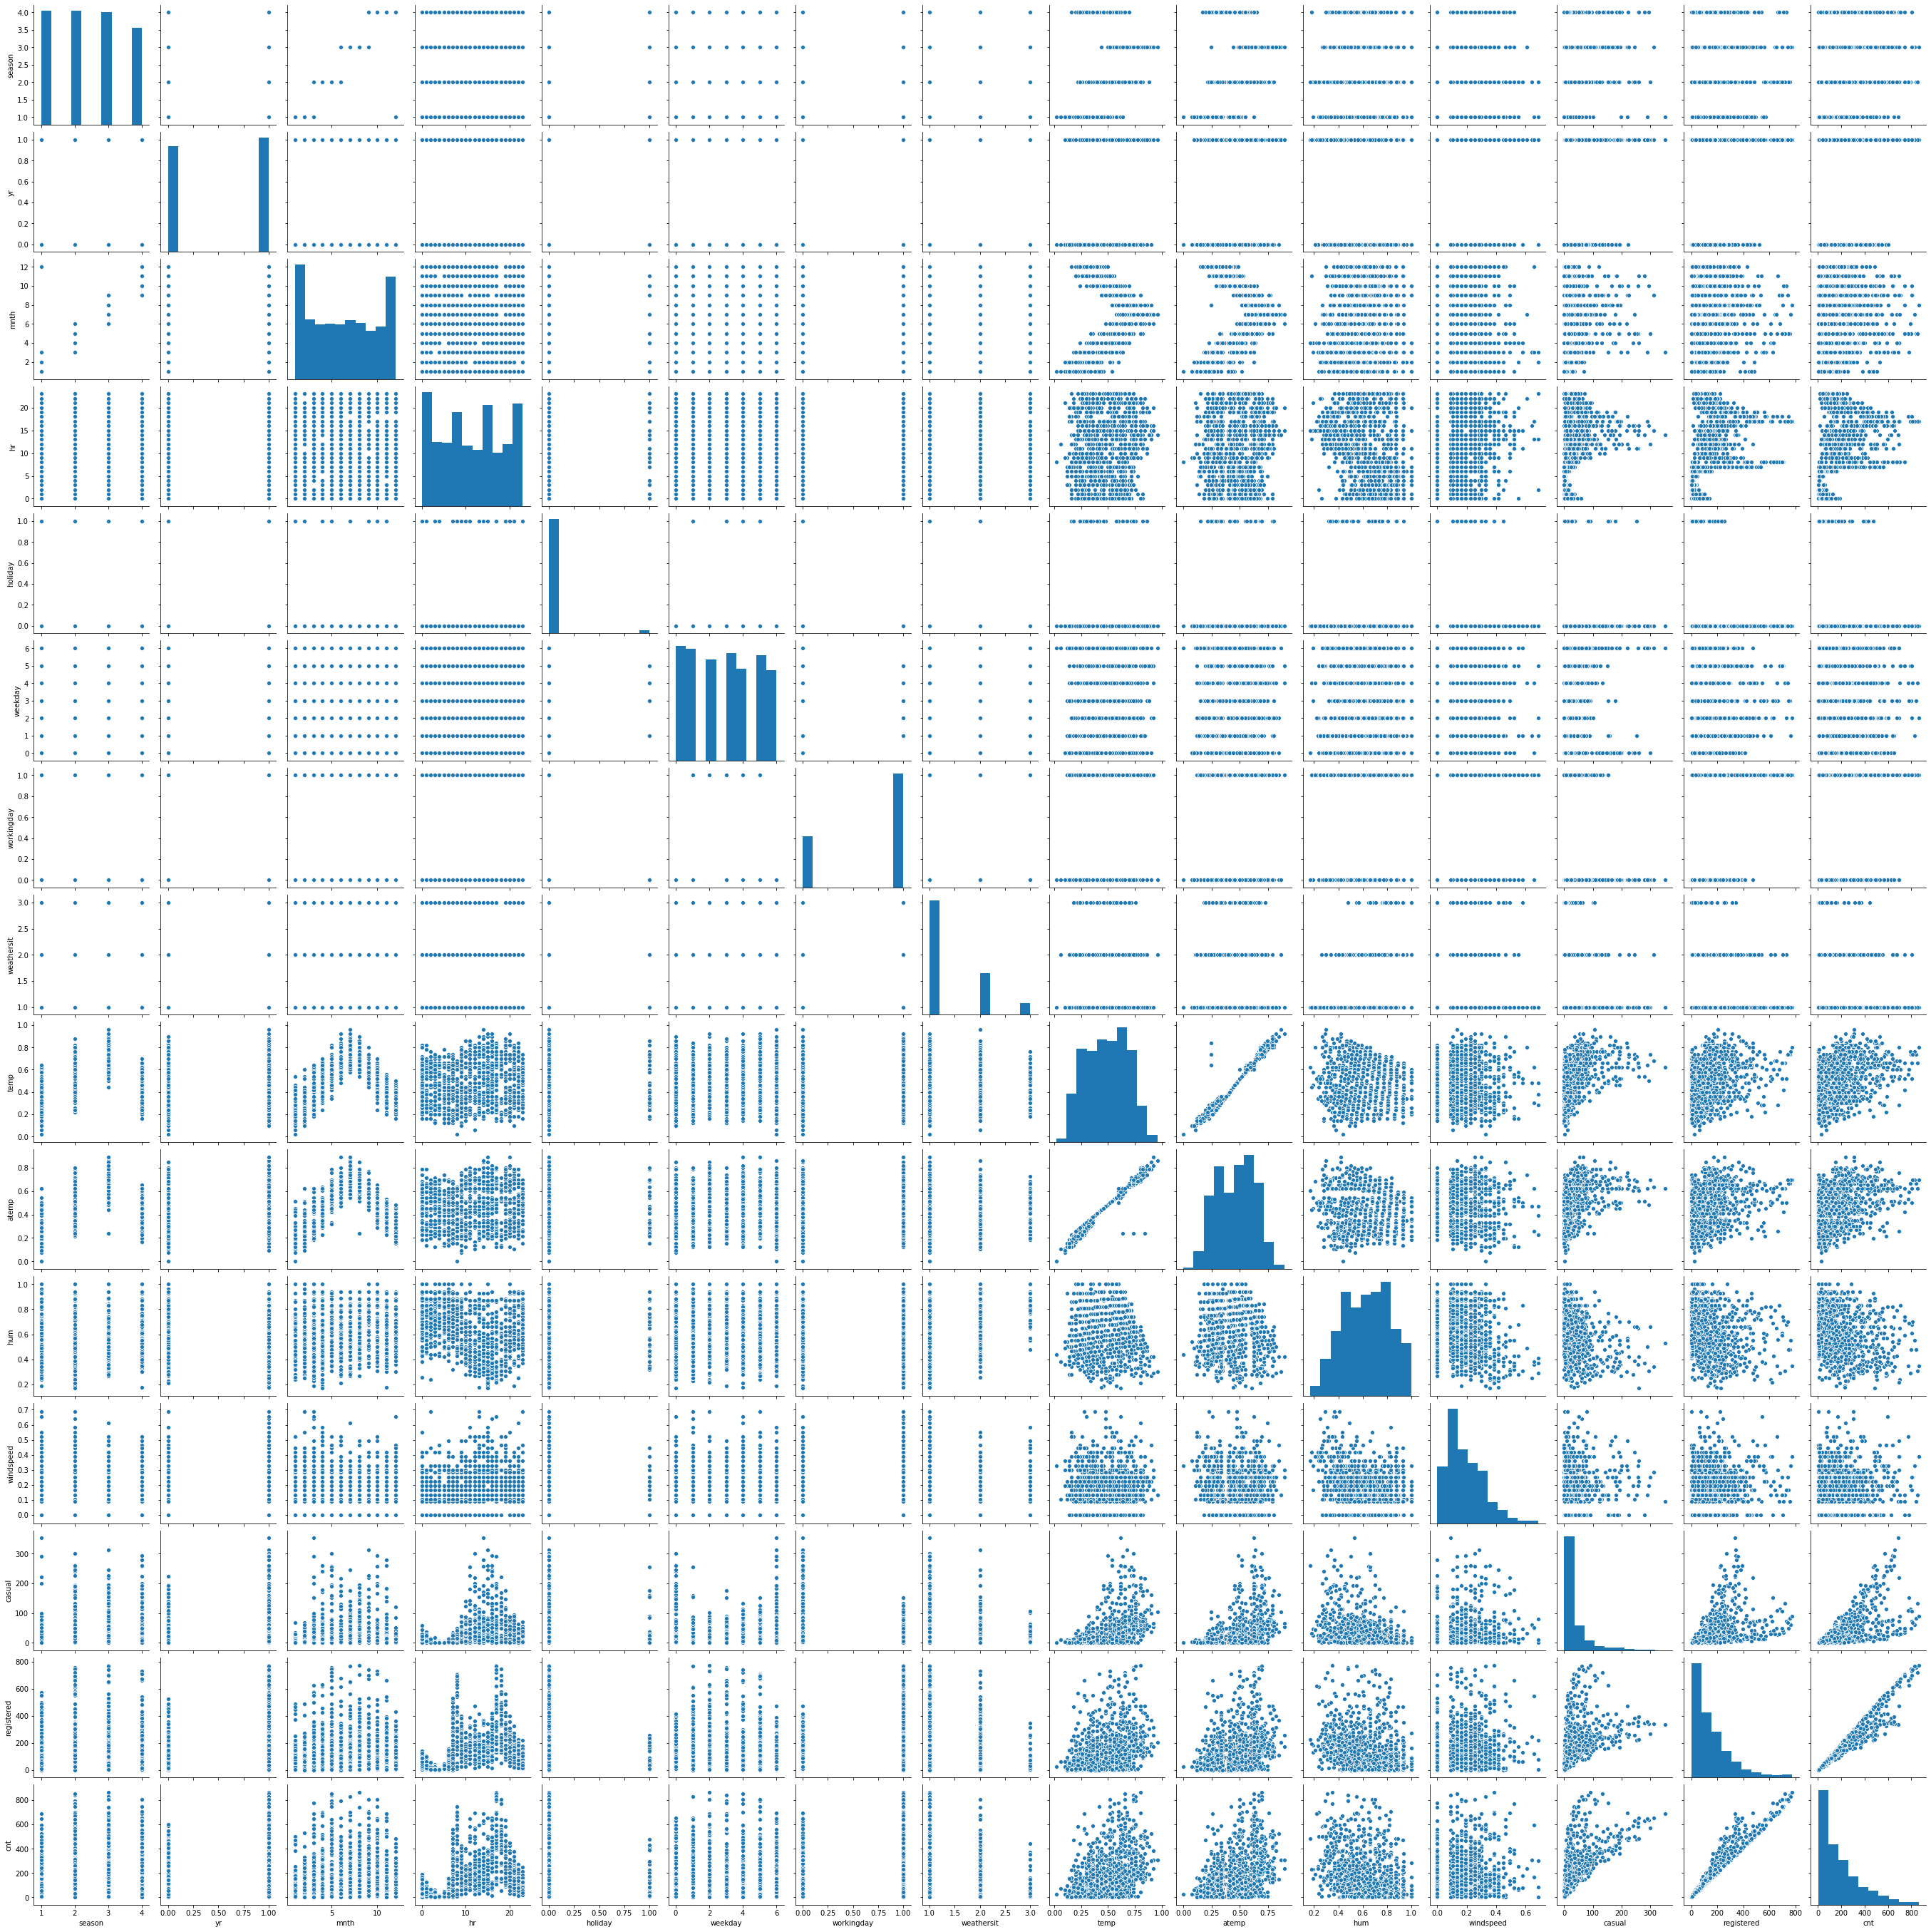

In [13]:
sns.pairplot(df.sample(1000))
plt.show()

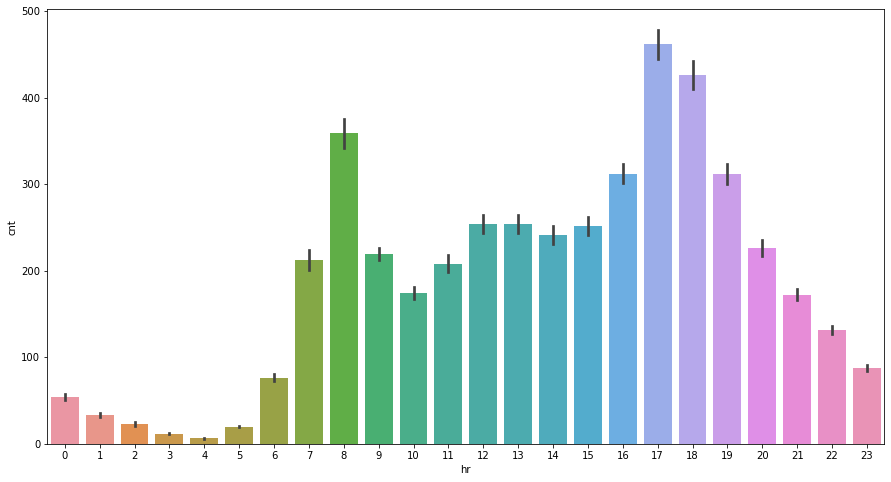

In [14]:
fig, ax = plt.subplots(figsize=(15,8))
sns.barplot(x=df.hr,y=df.cnt, ax=ax)
plt.show()

### Train a Regression Model

In [15]:
X = df.iloc[:,0:14]
y = df.iloc[:,14]

In [16]:
scaler = StandardScaler()

In [17]:
X_scaled = scaler.fit_transform(X)

In [18]:
X_scaled

array([[-1.3566343 , -1.0051343 , -1.61043792, ..., -1.55388851,
        -0.66275506, -0.93018925],
       [-1.3566343 , -1.0051343 , -1.61043792, ..., -1.55388851,
        -0.56134262, -0.80465484],
       [-1.3566343 , -1.0051343 , -1.61043792, ..., -1.55388851,
        -0.62219008, -0.83769021],
       ...,
       [-1.3566343 ,  0.99489192,  1.58846698, ..., -0.21169121,
        -0.58162511, -0.46769408],
       [-1.3566343 ,  0.99489192,  1.58846698, ..., -0.45609864,
        -0.45993017, -0.69894166],
       [-1.3566343 ,  0.99489192,  1.58846698, ..., -0.45609864,
        -0.48021266, -0.77161947]])

In [19]:
X_scaled_df = pd.DataFrame(X_scaled,columns=X.columns)

In [20]:
X_scaled_df

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered
0,-1.356634,-1.005134,-1.610438,-1.670004,-0.172112,1.493891,-1.46690,-0.665193,-1.334648,-1.093281,0.947372,-1.553889,-0.662755,-0.930189
1,-1.356634,-1.005134,-1.610438,-1.525374,-0.172112,1.493891,-1.46690,-0.665193,-1.438516,-1.181732,0.895539,-1.553889,-0.561343,-0.804655
2,-1.356634,-1.005134,-1.610438,-1.380744,-0.172112,1.493891,-1.46690,-0.665193,-1.438516,-1.181732,0.895539,-1.553889,-0.622190,-0.837690
3,-1.356634,-1.005134,-1.610438,-1.236115,-0.172112,1.493891,-1.46690,-0.665193,-1.334648,-1.093281,0.636370,-1.553889,-0.662755,-0.950010
4,-1.356634,-1.005134,-1.610438,-1.091485,-0.172112,1.493891,-1.46690,-0.665193,-1.334648,-1.093281,0.636370,-1.553889,-0.723603,-1.009474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,-1.356634,0.994892,1.588467,1.077962,-0.172112,-0.998987,0.68171,0.898924,-1.230779,-1.269602,-0.141137,-0.211691,-0.500495,-0.302517
17375,-1.356634,0.994892,1.588467,1.222591,-0.172112,-0.998987,0.68171,0.898924,-1.230779,-1.269602,-0.141137,-0.211691,-0.561343,-0.480908
17376,-1.356634,0.994892,1.588467,1.367221,-0.172112,-0.998987,0.68171,-0.665193,-1.230779,-1.269602,-0.141137,-0.211691,-0.581625,-0.467694
17377,-1.356634,0.994892,1.588467,1.511851,-0.172112,-0.998987,0.68171,-0.665193,-1.230779,-1.181732,-0.348473,-0.456099,-0.459930,-0.698942


In [21]:
label = df['cnt']

In [22]:
label

0         16
1         40
2         32
3         13
4          1
        ... 
17374    119
17375     89
17376     90
17377     61
17378     49
Name: cnt, Length: 17379, dtype: int64

In [23]:
df2 = pd.concat([X_scaled_df,label],axis=1)

In [24]:
df2

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,-1.356634,-1.005134,-1.610438,-1.670004,-0.172112,1.493891,-1.46690,-0.665193,-1.334648,-1.093281,0.947372,-1.553889,-0.662755,-0.930189,16
1,-1.356634,-1.005134,-1.610438,-1.525374,-0.172112,1.493891,-1.46690,-0.665193,-1.438516,-1.181732,0.895539,-1.553889,-0.561343,-0.804655,40
2,-1.356634,-1.005134,-1.610438,-1.380744,-0.172112,1.493891,-1.46690,-0.665193,-1.438516,-1.181732,0.895539,-1.553889,-0.622190,-0.837690,32
3,-1.356634,-1.005134,-1.610438,-1.236115,-0.172112,1.493891,-1.46690,-0.665193,-1.334648,-1.093281,0.636370,-1.553889,-0.662755,-0.950010,13
4,-1.356634,-1.005134,-1.610438,-1.091485,-0.172112,1.493891,-1.46690,-0.665193,-1.334648,-1.093281,0.636370,-1.553889,-0.723603,-1.009474,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,-1.356634,0.994892,1.588467,1.077962,-0.172112,-0.998987,0.68171,0.898924,-1.230779,-1.269602,-0.141137,-0.211691,-0.500495,-0.302517,119
17375,-1.356634,0.994892,1.588467,1.222591,-0.172112,-0.998987,0.68171,0.898924,-1.230779,-1.269602,-0.141137,-0.211691,-0.561343,-0.480908,89
17376,-1.356634,0.994892,1.588467,1.367221,-0.172112,-0.998987,0.68171,-0.665193,-1.230779,-1.269602,-0.141137,-0.211691,-0.581625,-0.467694,90
17377,-1.356634,0.994892,1.588467,1.511851,-0.172112,-0.998987,0.68171,-0.665193,-1.230779,-1.181732,-0.348473,-0.456099,-0.459930,-0.698942,61


In [25]:
#Save to csv
#df2.to_csv("train.csv",index=False)

In [26]:
X = df2.iloc[:,0:14]
y = df2.iloc[:,14]

In [27]:
X.values, y.values

(array([[-1.3566343 , -1.0051343 , -1.61043792, ..., -1.55388851,
         -0.66275506, -0.93018925],
        [-1.3566343 , -1.0051343 , -1.61043792, ..., -1.55388851,
         -0.56134262, -0.80465484],
        [-1.3566343 , -1.0051343 , -1.61043792, ..., -1.55388851,
         -0.62219008, -0.83769021],
        ...,
        [-1.3566343 ,  0.99489192,  1.58846698, ..., -0.21169121,
         -0.58162511, -0.46769408],
        [-1.3566343 ,  0.99489192,  1.58846698, ..., -0.45609864,
         -0.45993017, -0.69894166],
        [-1.3566343 ,  0.99489192,  1.58846698, ..., -0.45609864,
         -0.48021266, -0.77161947]]),
 array([16, 40, 32, ..., 90, 61, 49], dtype=int64))

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [29]:
X_train.shape, X_test.shape

((12165, 14), (5214, 14))

In [30]:
xgb = XGBRegressor(random_state=123, n_estimators=1400, objective='reg:squarederror')

In [31]:
xgb.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='rmse',early_stopping_rounds=20)

[0]	validation_0-rmse:238.27
Will train until validation_0-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:215.427
[2]	validation_0-rmse:194.793
[3]	validation_0-rmse:176.14
[4]	validation_0-rmse:159.392
[5]	validation_0-rmse:144.189
[6]	validation_0-rmse:130.483
[7]	validation_0-rmse:118.268
[8]	validation_0-rmse:107.135
[9]	validation_0-rmse:97.0808
[10]	validation_0-rmse:88.1531
[11]	validation_0-rmse:79.9275
[12]	validation_0-rmse:72.6785
[13]	validation_0-rmse:66.0022
[14]	validation_0-rmse:60.0368
[15]	validation_0-rmse:54.7231
[16]	validation_0-rmse:49.9424
[17]	validation_0-rmse:45.5686
[18]	validation_0-rmse:41.6231
[19]	validation_0-rmse:38.1251
[20]	validation_0-rmse:34.9144
[21]	validation_0-rmse:32.0074
[22]	validation_0-rmse:29.3382
[23]	validation_0-rmse:26.9724
[24]	validation_0-rmse:24.8599
[25]	validation_0-rmse:22.9298
[26]	validation_0-rmse:21.2045
[27]	validation_0-rmse:19.6766
[28]	validation_0-rmse:18.2447
[29]	validation_0-rmse:16.9786
[30]	validation_0

[259]	validation_0-rmse:3.57283
[260]	validation_0-rmse:3.56222
[261]	validation_0-rmse:3.54787
[262]	validation_0-rmse:3.54561
[263]	validation_0-rmse:3.54422
[264]	validation_0-rmse:3.54192
[265]	validation_0-rmse:3.54182
[266]	validation_0-rmse:3.53907
[267]	validation_0-rmse:3.53651
[268]	validation_0-rmse:3.52754
[269]	validation_0-rmse:3.52519
[270]	validation_0-rmse:3.52066
[271]	validation_0-rmse:3.51257
[272]	validation_0-rmse:3.49946
[273]	validation_0-rmse:3.49332
[274]	validation_0-rmse:3.48681
[275]	validation_0-rmse:3.48434
[276]	validation_0-rmse:3.48141
[277]	validation_0-rmse:3.47273
[278]	validation_0-rmse:3.47175
[279]	validation_0-rmse:3.46703
[280]	validation_0-rmse:3.46139
[281]	validation_0-rmse:3.45017
[282]	validation_0-rmse:3.44331
[283]	validation_0-rmse:3.43642
[284]	validation_0-rmse:3.42191
[285]	validation_0-rmse:3.41785
[286]	validation_0-rmse:3.41183
[287]	validation_0-rmse:3.40312
[288]	validation_0-rmse:3.39003
[289]	validation_0-rmse:3.38612
[290]	va

[516]	validation_0-rmse:2.72053
[517]	validation_0-rmse:2.71846
[518]	validation_0-rmse:2.71935
[519]	validation_0-rmse:2.71771
[520]	validation_0-rmse:2.71428
[521]	validation_0-rmse:2.71126
[522]	validation_0-rmse:2.7098
[523]	validation_0-rmse:2.71016
[524]	validation_0-rmse:2.70998
[525]	validation_0-rmse:2.70868
[526]	validation_0-rmse:2.70773
[527]	validation_0-rmse:2.70575
[528]	validation_0-rmse:2.70507
[529]	validation_0-rmse:2.70226
[530]	validation_0-rmse:2.70126
[531]	validation_0-rmse:2.69951
[532]	validation_0-rmse:2.69715
[533]	validation_0-rmse:2.69475
[534]	validation_0-rmse:2.69232
[535]	validation_0-rmse:2.69057
[536]	validation_0-rmse:2.68858
[537]	validation_0-rmse:2.68729
[538]	validation_0-rmse:2.68655
[539]	validation_0-rmse:2.68456
[540]	validation_0-rmse:2.68154
[541]	validation_0-rmse:2.67721
[542]	validation_0-rmse:2.67297
[543]	validation_0-rmse:2.67171
[544]	validation_0-rmse:2.66998
[545]	validation_0-rmse:2.66868
[546]	validation_0-rmse:2.66606
[547]	val

[773]	validation_0-rmse:2.36583
[774]	validation_0-rmse:2.36413
[775]	validation_0-rmse:2.36411
[776]	validation_0-rmse:2.36363
[777]	validation_0-rmse:2.36242
[778]	validation_0-rmse:2.36256
[779]	validation_0-rmse:2.36178
[780]	validation_0-rmse:2.36156
[781]	validation_0-rmse:2.36093
[782]	validation_0-rmse:2.35767
[783]	validation_0-rmse:2.35433
[784]	validation_0-rmse:2.35244
[785]	validation_0-rmse:2.35075
[786]	validation_0-rmse:2.34943
[787]	validation_0-rmse:2.34803
[788]	validation_0-rmse:2.3467
[789]	validation_0-rmse:2.34649
[790]	validation_0-rmse:2.34444
[791]	validation_0-rmse:2.34376
[792]	validation_0-rmse:2.34307
[793]	validation_0-rmse:2.3407
[794]	validation_0-rmse:2.33913
[795]	validation_0-rmse:2.33854
[796]	validation_0-rmse:2.33706
[797]	validation_0-rmse:2.33648
[798]	validation_0-rmse:2.33576
[799]	validation_0-rmse:2.33563
[800]	validation_0-rmse:2.33627
[801]	validation_0-rmse:2.33594
[802]	validation_0-rmse:2.33537
[803]	validation_0-rmse:2.33527
[804]	vali

[1030]	validation_0-rmse:2.14871
[1031]	validation_0-rmse:2.14845
[1032]	validation_0-rmse:2.14813
[1033]	validation_0-rmse:2.14762
[1034]	validation_0-rmse:2.14573
[1035]	validation_0-rmse:2.14529
[1036]	validation_0-rmse:2.14325
[1037]	validation_0-rmse:2.14264
[1038]	validation_0-rmse:2.14269
[1039]	validation_0-rmse:2.14162
[1040]	validation_0-rmse:2.14136
[1041]	validation_0-rmse:2.13969
[1042]	validation_0-rmse:2.13916
[1043]	validation_0-rmse:2.13829
[1044]	validation_0-rmse:2.13738
[1045]	validation_0-rmse:2.136
[1046]	validation_0-rmse:2.13421
[1047]	validation_0-rmse:2.13279
[1048]	validation_0-rmse:2.13233
[1049]	validation_0-rmse:2.13193
[1050]	validation_0-rmse:2.13091
[1051]	validation_0-rmse:2.13106
[1052]	validation_0-rmse:2.13135
[1053]	validation_0-rmse:2.13084
[1054]	validation_0-rmse:2.12995
[1055]	validation_0-rmse:2.12873
[1056]	validation_0-rmse:2.12807
[1057]	validation_0-rmse:2.12744
[1058]	validation_0-rmse:2.12581
[1059]	validation_0-rmse:2.12452
[1060]	valid

[1280]	validation_0-rmse:2.01741
[1281]	validation_0-rmse:2.01713
[1282]	validation_0-rmse:2.01711
[1283]	validation_0-rmse:2.01668
[1284]	validation_0-rmse:2.0166
[1285]	validation_0-rmse:2.01609
[1286]	validation_0-rmse:2.01558
[1287]	validation_0-rmse:2.01499
[1288]	validation_0-rmse:2.01428
[1289]	validation_0-rmse:2.01375
[1290]	validation_0-rmse:2.01328
[1291]	validation_0-rmse:2.01155
[1292]	validation_0-rmse:2.01169
[1293]	validation_0-rmse:2.0117
[1294]	validation_0-rmse:2.01187
[1295]	validation_0-rmse:2.01179
[1296]	validation_0-rmse:2.01153
[1297]	validation_0-rmse:2.01142
[1298]	validation_0-rmse:2.011
[1299]	validation_0-rmse:2.01096
[1300]	validation_0-rmse:2.01109
[1301]	validation_0-rmse:2.01102
[1302]	validation_0-rmse:2.01085
[1303]	validation_0-rmse:2.01088
[1304]	validation_0-rmse:2.01057
[1305]	validation_0-rmse:2.00995
[1306]	validation_0-rmse:2.00983
[1307]	validation_0-rmse:2.00853
[1308]	validation_0-rmse:2.00853
[1309]	validation_0-rmse:2.00841
[1310]	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1400,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [32]:
y_pred = xgb.predict(X_test)

In [33]:
y_pred

array([296.33707, 312.2723 ,  83.21583, ..., 316.03842, 166.3719 ,
       161.51761], dtype=float32)

In [34]:
mse = mean_squared_error(y_test,y_pred)
mse

3.83724937587087

In [35]:
rmse = np.sqrt(mse)
rmse

1.9588898324997426

In [36]:
r2score = r2_score(y_test,y_pred)
r2score

0.999885143707623

Text(0.5, 0, 'Actual')

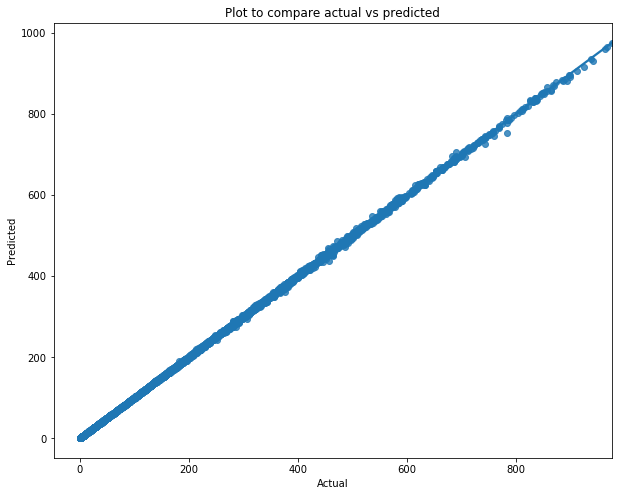

In [37]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")

In [38]:
EPSILON = 1e-10
def rae(actual: np.ndarray, predicted: np.ndarray):
    """ Relative Absolute Error (aka Approximation Error) """
    return np.sum(np.abs(actual - predicted)) / (np.sum(np.abs(actual - np.mean(actual))) + EPSILON)

In [39]:
rae(y_test,y_pred)

0.007674801329396086